## Anomaly Detection with Bayesian Networks, Clustering and Gaussian Process Regression

## Gaussian Process Regression on Pittsburg Traffic Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import permutations
import matplotlib.pyplot as plt 

%pylab inline
np.random.seed(20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#upload data
traffic = pd.read_csv("PittsburghTrafficCounts.csv")
traffic.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
#take log of the daily traffic counts and adjust based on mean of log column
traffic['log_counts'] = np.log(traffic['AvgDailyTrafficCount'])
traffic['log_counts_adj'] = traffic['log_counts'] - traffic['log_counts'].mean()

In [4]:
#set x and y variables and split into training and test set
y = traffic['log_counts_adj']
x = traffic.iloc[:,:2]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1)

In [5]:
#loop over set of kernel options and find optimal kernel
noise_levels = list(permutations(np.linspace(1,10,10),2))
log_likelihoods = []
kernels = []
for i in noise_levels:
    kernel= 1 * RBF(length_scale=i[0]) + WhiteKernel(noise_level=i[1])
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(x_train,y_train)
    y_pred, sigma = gp.predict(x_val, return_std=True)
    log_likelihoods.append(gp.log_marginal_likelihood_value_)
    kernels.append(gp.kernel_)  

In [6]:
print("best log likelihood: {}".format(max(log_likelihoods)))
print("kernel with the best log likelihood: {}".format(kernels[log_likelihoods.index(max(log_likelihoods))]))

best log likelihood: -833.8174864061984
kernel with the best log likelihood: 0.597**2 * RBF(length_scale=0.0344) + WhiteKernel(noise_level=0.566)


### Plot Heatmap

In [7]:
xv, yv = np.meshgrid(x_test['Longitude'], x_test['Latitude'])

In [8]:
xv, yv = xv.ravel(), yv.ravel()
xv = pd.DataFrame(xv)
yv = pd.DataFrame(yv)
x_mesh = pd.merge(xv,yv,left_index=True,right_index=True)

In [9]:
#generate prediction values
kernel = kernels[log_likelihoods.index(max(log_likelihoods))]
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x_train,y_train)

y_pred, sigma = gp.predict(x_mesh, return_std=True)

In [10]:
test_preds, sigma_test = gp.predict(x_test, return_std=True)

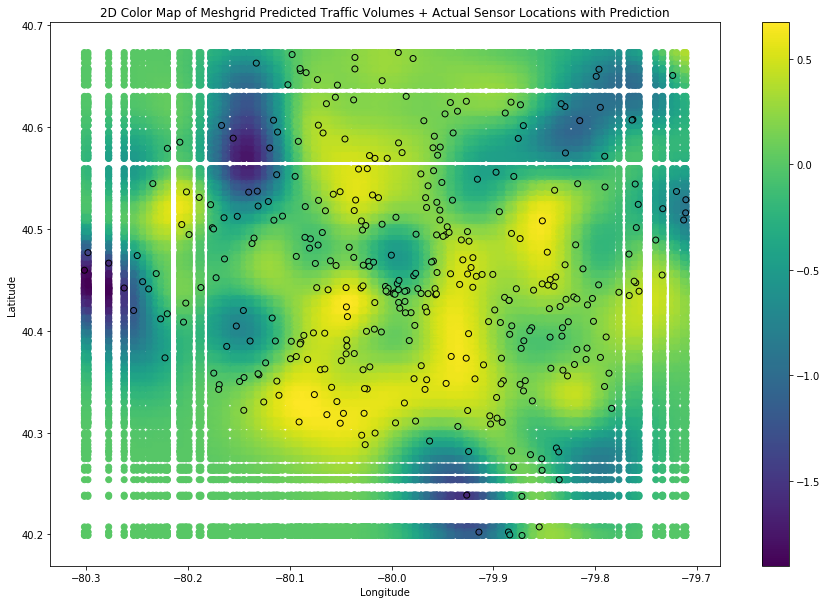

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

scat = ax.scatter(x_mesh['0_x'], x_mesh['0_y'],c=y_pred)
ax.scatter(x_test['Longitude'],x_test['Latitude'],c=test_preds,edgecolors='black')

ax.set_title("2D Color Map of Meshgrid Predicted Traffic Volumes + Actual Sensor Locations with Prediction")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(scat, ax=ax)
plt.show()

In [14]:
x_test.head()

,Longitude,Latitude
731,-80.094854,40.551586
680,-80.069920,40.361725
525,-80.032478,40.558760
918,-79.925207,40.321607
434,-79.947445,40.612943


In [15]:
#convert to dataframe and merge
ytest_df = pd.DataFrame(y_test)
predtest_df = pd.DataFrame(test_preds)
sigmatest_df = pd.DataFrame(sigma_test)

ytest_df.reset_index(inplace=True)

#merge dfs
test_df = pd.merge(left=ytest_df,right=predtest_df,left_index=True,right_index=True)
test_df = pd.merge(left=test_df,right=sigmatest_df,left_index=True,right_index=True)

In [16]:
test_df.head()

,index,log_counts_adj,0_x,0_y
0,731,0.591647,-0.150813,0.797110
1,680,0.523474,0.485186,0.788823
2,525,0.206522,0.537688,0.798290
3,918,0.799394,0.396543,0.789438
4,434,0.001711,0.133822,0.846505


In [17]:
#set upper and lower bounds with standard deviation
test_df['lower_bound'] = test_df['0_x'] - (1.96 * test_df['0_y'])
test_df['upper_bound'] = test_df['0_x'] + (1.96 * test_df['0_y'])

In [21]:
test_df['lower'] = ((test_df['log_counts_adj'] - test_df['log_counts_adj'].mean()) < test_df['lower_bound'])
test_df['higher'] = ((test_df['log_counts_adj'] - test_df['log_counts_adj'].mean()) > test_df['upper_bound'])

In [23]:
test_df.groupby('lower')['0_x'].count()

lower
False    349
True      19
Name: 0_x, dtype: int64

In [24]:
test_df.groupby('higher')['0_x'].count()

higher
False    367
True       1
Name: 0_x, dtype: int64

In [25]:
print("There are 19 values below two standard deviations")
print("there is one value above two standard deviations")

There are 19 values below two standard deviations
there is one value above two standard deviations


In [30]:
#join sigma deviation flags into lat-lon data set
x_test.reset_index(inplace=True)

x_test = pd.merge(left=x_test,right=test_df,left_index=True,right_index=True)

below_df = x_test[x_test['lower']==True]
above_df = x_test[x_test['higher']==True]
inbetween_df = x_test[(x_test['higher']==False)&(x_test['lower']==False)]

In [26]:
#filter dfs for graphing
below_df = test_df[test_df['lower']==True]
above_df = test_df[test_df['higher']==True]
inbetween_df = test_df[(test_df['higher']==False)&(test_df['lower']==False)]

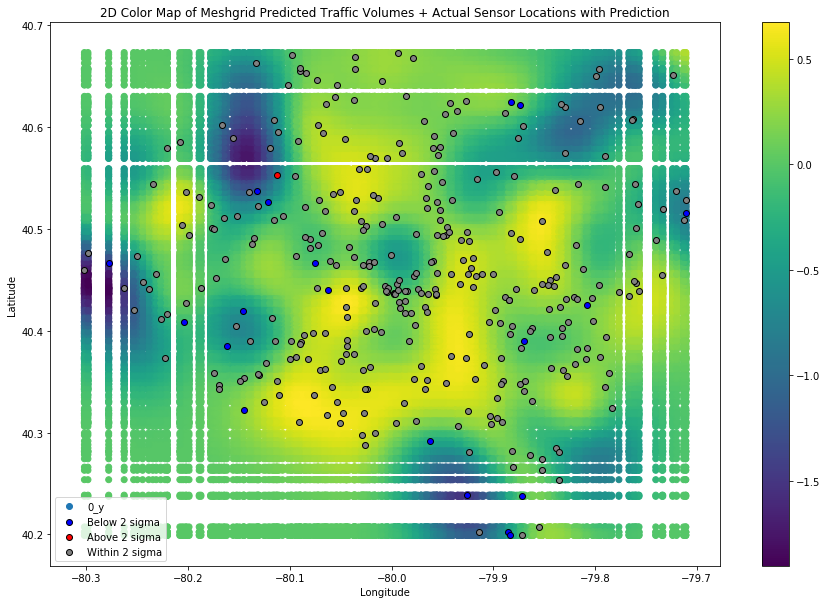

In [35]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

scat = ax.scatter(x_mesh['0_x'], x_mesh['0_y'],c=y_pred)
ax.scatter(below_df['Longitude'],below_df['Latitude'],c='blue',edgecolors='black',label='Below 2 sigma')
ax.scatter(above_df['Longitude'],above_df['Latitude'],c='red',edgecolors='black',label='Above 2 sigma')
ax.scatter(inbetween_df['Longitude'],inbetween_df['Latitude'],c='grey',edgecolors='black',label='Within 2 sigma')

ax.set_title("2D Color Map of Meshgrid Predicted Traffic Volumes + Actual Sensor Locations with Prediction")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(scat, ax=ax)
plt.legend()
plt.show()

### Bayesian Network Anomaly Detection

In [2]:
import pandas as pd
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [3]:
#put counties in the index
Data2.set_index('County',inplace=True)

In [4]:
#filter only to needed columns
Data2 = Data2[["'\% Smokers'",
 "'\% Obese'","'Violent Crime Rate'",
 "'80/20 Income Ratio'",
 "'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [5]:
#make sure columns are numeric
cols = Data2.columns
Data2[cols] = Data2[cols].apply(pd.to_numeric,errors='coerce')

In [6]:
Data2.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",19.0,31,254.0,4.3,18.0,12.9
"Baldwin, Alabama",19.0,27,221.0,4.5,20.0,13.1
"Barbour, Alabama",21.0,41,147.0,5.3,38.0,12.6
"Bibb, Alabama",21.0,40,236.0,4.3,27.0,12.9
"Blount, Alabama",19.0,32,219.0,4.1,24.0,12.7


In [7]:
#take quintiles of variables
Data2["smoker_quintile"] = pd.qcut(Data2["'\% Smokers'"],5,labels=False)
Data2["obese_quintile"] = pd.qcut(Data2["'\% Obese'"],5,labels=False)
Data2['crime_quintile'] = pd.qcut(Data2["'\% Obese'"],5,labels=False)
Data2['income_quintile'] = pd.qcut(Data2["'80/20 Income Ratio'"],5,labels=False)
Data2['poverty_quintile'] = pd.qcut(Data2["'\% Children in Poverty'"],5,labels=False)
Data2['pm_quintile'] = pd.qcut(Data2["'Average Daily PM2.5'"],5,labels=False)

In [9]:
#drop un needed columns
Data2.drop(columns=["'\% Smokers'",
 "'\% Obese'","'Violent Crime Rate'",
 "'80/20 Income Ratio'",
 "'\% Children in Poverty'","'Average Daily PM2.5'"],axis=1,inplace=True)

In [11]:
#initialize hill climb search estimator
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(Data2, scoring_method=BicScore(Data2))

In [12]:
#show best model edges
best_model = hc.estimate()
print(best_model.edges())

[('smoker_quintile', 'poverty_quintile'), ('smoker_quintile', 'pm_quintile'), ('obese_quintile', 'crime_quintile'), ('obese_quintile', 'smoker_quintile'), ('poverty_quintile', 'income_quintile')]


In [14]:
#learn bayesian network parameters
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(Data2, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of crime_quintile:
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| obese_quintile    | obese_quintile(0) | obese_quintile(1) | obese_quintile(2) | obese_quintile(3) | obese_quintile(4) |
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| crime_quintile(0) | 1.0               | 0.0               | 0.0               | 0.0               | 0.0               |
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| crime_quintile(1) | 0.0               | 1.0               | 0.0               | 0.0               | 0.0               |
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| crime_quintile(2) | 0.0               | 0.0               | 1.0               | 0.0               | 0.0               |
+

In [27]:
import numpy as np

In [28]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [29]:
Data2.reset_index(inplace=True)

In [38]:
#do some cleaning up 

test_logs = Data2.iloc[:,2:]

test_logs.dropna(inplace=True)
test_logs['smoker_quintile'] = test_logs['smoker_quintile'].astype(int)
test_logs['income_quintile'] = test_logs['income_quintile'].astype(int)
test_logs['poverty_quintile'] = test_logs['poverty_quintile'].astype(int)
test_logs['pm_quintile'] = test_logs['pm_quintile'].astype(int)

test_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3140
Data columns (total 6 columns):
smoker_quintile     3107 non-null int64
obese_quintile      3107 non-null int64
crime_quintile      3107 non-null int64
income_quintile     3107 non-null int64
poverty_quintile    3107 non-null int64
pm_quintile         3107 non-null int64
dtypes: int64(6)
memory usage: 169.9 KB


In [39]:
#compute the log likelihoods
exmp = test_logs.apply(lambda x: LL(x,model),axis=1)

In [41]:
exmp.sort_values().head(5)

2018   -13.299167
1554   -12.751252
3009   -12.036658
3021   -12.016109
2000   -11.984656
dtype: float64

In [43]:
index_list = [2018,1554,3009,3021,2000]
Data2['County'][Data2.index.isin(index_list)]

1554            Nodaway, Missouri
2000           Dunn, North Dakota
2018      Mountrail, North Dakota
3009     Jefferson, West Virginia
3021    Monongalia, West Virginia
Name: County, dtype: object

## Clustering and Anomaly Detection

### K-means

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [6]:
data2=pd.read_csv("2016CountyHealthIndicators.csv")
data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [7]:
data2.set_index('County',inplace=True)

In [8]:
cols = data2.columns
data2[cols] = data2[cols].apply(pd.to_numeric,errors='coerce')

In [9]:
data2.dropna(inplace=True)

In [10]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(data2)
scaled_df = pd.DataFrame(scaled_x,columns=data2.columns)

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
score = KM.fit_predict(scaled_df)

In [16]:
kmeans_df = pd.DataFrame(KM.transform(scaled_df))

In [19]:
kmeans_df = pd.concat((kmeans_df,pd.DataFrame(score)),axis=1)

In [22]:
#add distance to home cluster
kmeans_df.columns =[0,1,2,'cluster']
kmeans_df['dist_to_clus'] = kmeans_df.apply(lambda x: x[int(x["cluster"])],axis=1)

In [23]:
#show head
kmeans_df.head()

,0,1,2,cluster,dist_to_clus
0,4.747200,4.823198,3.010345,2,3.010345
1,3.947309,5.417499,2.686855,2,2.686855
2,9.875072,4.020689,6.812540,1,4.020689
3,7.386128,3.512700,4.717453,1,3.512700
4,6.361800,5.357806,4.482549,2,4.482549


In [26]:
#add county names back to cluster info
data2.reset_index(inplace=True)
county_list = pd.DataFrame(data2['County'])
kmeans_df = pd.merge(left=kmeans_df,right=county_list,left_index=True,right_index=True)

In [29]:
#print largest deviation clusters
kmeans_df.nlargest(5,'dist_to_clus')['County']

1890    Shannon, South Dakota
1444       New York, New York
66            Apache, Arizona
1417          Bronx, New York
1437          Kings, New York
Name: County, dtype: object

### Using Gaussian Mixture

In [30]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(scaled_df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [35]:
#print Gaussian mixture results
gm_df = pd.DataFrame(GM.score_samples(scaled_df))
gm_df = pd.merge(left=gm_df,right=county_list,left_index=True,right_index=True)

gm_df.sort_values(by=0)[:5]

,0,County
1890,-125.936770,"Shannon, South Dakota"
1444,-73.568361,"New York, New York"
66,-70.449672,"Apache, Arizona"
157,-69.026168,"Imperial, California"
1577,-68.036921,"Roulette, North Dakota"


### Using Local Outlier Factor

In [45]:
scaled_df.shape

(2486, 30)

In [54]:
from sklearn.neighbors import LocalOutlierFactor

#set contamination to 0.5 so scores can be obtained for all values
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.5) 
y_pred = clf.fit_predict(scaled_df)

In [56]:
#find outlier scores
X_scores = clf.negative_outlier_factor_

In [57]:
lof_df = pd.DataFrame(X_scores)

In [59]:
lof_df = pd.DataFrame(X_scores)
county_list = pd.DataFrame(data2['County'])
lof_df = pd.merge(left=lof_df,right=county_list,left_index=True,right_index=True)

In [60]:
lof_df.sort_values(by=0,inplace=True)

In [62]:
#print top five outlier counties
lof_df.head()

,0,County
1890,-2.614655,"Shannon, South Dakota"
2299,-1.924318,"Manassas Park City, Virginia"
66,-1.904558,"Apache, Arizona"
1444,-1.903328,"New York, New York"
1620,-1.856231,"Holmes, Ohio"


In [65]:
county_list = ['Shannon, South Dakota', 'Manassas Park City, Virginia', 
'Apache, Arizona', 'New York, New York', 'Holmes, Ohio',
 'Imperial, California','Roulette, North Dakota','Bronx, New York','Kings, New York']

In [69]:
#set option to see all columns
pd.set_option('display.max_columns', 500)

In [70]:
data2[data2['County'].isin(county_list)]

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured','Preventable Hosp. Rate','\% Dibetics receiving HbA1c','\% Mammography','Graduation Rate','\% Some College','\% Unemployed','\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
66,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33,0.5,22,22.0,15.0,20.0,822.0,55.0,24.0,89.0,28.0,39.0,66.0,47.5,16.0,40.0,6.3,52.0,3.5,94.0,173.0,9.8,36,75.0,42.0
157,"Imperial, California",28.0,4.8,4.2,6.0,14.0,25,6.5,22,69.0,17.0,21.0,334.0,57.0,21.0,48.0,85.0,46.0,85.0,51.9,23.6,31.0,5.6,34.0,4.8,304.0,43.0,9.4,28,80.0,21.0
1417,"Bronx, New York",29.0,5.0,4.3,10.0,19.0,29,7.0,29,99.0,14.0,13.0,1144.0,40.0,16.0,58.0,70.0,61.0,56.0,49.1,9.8,43.0,6.4,63.0,2.6,620.0,38.0,10.8,38,23.0,50.0
1437,"Kings, New York",20.0,4.0,3.9,8.0,16.0,22,6.8,26,97.0,17.0,14.0,694.0,28.0,15.0,58.0,86.0,57.0,65.0,62.6,7.7,33.0,6.4,39.0,4.5,633.0,32.0,10.8,35,19.0,54.0
1444,"New York, New York",14.0,3.5,3.5,9.0,13.0,15,7.8,18,98.0,21.0,10.0,706.0,21.0,11.0,42.0,81.0,61.0,66.0,83.0,6.1,24.0,8.7,41.0,13.0,620.0,32.0,10.8,25,6.0,63.0
1577,"Roulette, North Dakota",29.0,5.1,4.5,10.0,38.0,41,6.9,34,21.0,20.0,59.0,1203.0,96.0,21.0,117.0,40.0,45.0,68.0,62.4,11.8,41.0,7.7,59.0,6.2,29.0,104.0,9.6,21,84.0,14.0
1620,"Holmes, Ohio",17.0,3.8,4.2,5.0,20.0,28,8.0,27,26.0,18.0,38.0,79.0,15.0,24.0,53.0,85.0,52.0,98.0,22.2,3.9,19.0,3.5,7.0,11.9,36.0,38.0,13.9,16,52.0,26.0
1890,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45,1.6,24,2.0,16.0,68.0,2653.0,110.0,17.0,161.0,19.0,26.0,3.0,51.8,13.2,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44,64.0,22.0
2299,"Manassas Park City, Virginia",17.0,3.4,3.1,6.0,17.0,30,9.3,24,92.0,17.0,100.0,247.0,20.0,23.0,41.0,85.0,52.0,75.0,57.6,4.5,15.0,3.4,26.0,5.0,115.0,27.0,12.7,18,73.0,57.0


There is some similiarity across the model results. In particular, highly anamolous counties such as Shannon, SD, Apache, AZ, and New York, NY appear in all three clustering methods whereas some clusters generate anomalies in counties that appear on through that method, e.g. Holmes, OH in the LOF method and Imperial California with the Gaussian mixture approach. Not surprisingly, when counties appear from all three methods they are very clear anomalies across a larger number of variables.

Sub-select of variables Driving Outlier Assignment:

Apache, Arizona: Chlamydia, Food Environment Index, % Dibetics receiving HbA1c <br/>
Imperial, California: % Unemployed<br/>
Bronx, NY: Chlamydia, Violent Crime Rate, Violent Crime Rate<br/>
Kings, NY: Violent Crime Rate<br/>
New York, NY: Chlamydia, Violent Crime Rate<br/>
Roulette, ND: Chlamydia Rate, % Obese, Teen Birth Rate, Preventable Hosp. Rate<br/>
Holmes, OH: Average Daily PM2.5<br/>
Shannon, SD: Chlamydia Rate, % With Access To Exercise, Graduation Rate, % Smokers, Single Parent Households, % Obese, Food Environment Index, Teen Birth Rate, % Dibetics receiving HbA1c<br/>
Manassess Park, VA: % Alcohol-Impaired Driving Deaths<br/>